# Multinomial Naïve Bayes Classifier - the YouTube Dataset

### Introducing the database

The dataset for this example has been splitted in 5 csv files just to give a more real life feeling to the example, since joining files is a data scientist's common operation.

Although the dataset has more columns, we'll only be interested in the column `CONTENT` (containing the comment text) and the `CLASS` column (if 0 is ham, if 1 is spam). 

### Importing the necessary libraries

In [1]:
# A module for handling data
import pandas as pd
# A module that helps finding all pathnames that match a certain pattern
import glob

# A class that will be used to count the number of times a word has occurred in a text
from sklearn.feature_extraction.text import CountVectorizer

# A method used to split the dataset into training and testing
from sklearn.model_selection import train_test_split

# The multinomial type of the Naive Bayes classfier
from sklearn.naive_bayes import MultinomialNB

# Importing different metrics that would allow us to evaluate our model
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Python's plotting module. 
# We improve the graphics by overriding the default matplotlib styles with those of seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# The Python package for scientific computing
import numpy as np

### Reading the database

In [2]:
# Using the 'glob()' method, create a variable of type 'list' called 'files'. 
# It stores the paths of all files in the folder 'youtube-dataset' whose extension is .csv.
files = glob.glob('data/youtube-dataset/*.csv')
files

['data/youtube-dataset/Youtube03.csv',
 'data/youtube-dataset/Youtube01.csv',
 'data/youtube-dataset/Youtube02.csv',
 'data/youtube-dataset/Youtube04.csv',
 'data/youtube-dataset/Youtube05.csv']

In [3]:
# An empty array which will be used to store all 5 dataframes corresponding to the 5 .csv files. 
all_df = []

# Run a for-loop where the iterator 'i' goes through each filename in the 'files' array.
# During each iteration, create a pandas DataFrame by reading the current .csv file. 
# Drop the unneccesary columns (along axis 1) and append the dataframe to the 'all_df' list.
for i in files:
    all_df.append(pd.read_csv(i).drop(['COMMENT_ID', 'AUTHOR', 'DATE'], axis = 1))

In [4]:
# Look at the first item in the list
all_df[0]

,CONTENT,CLASS
0,"<a href=""http://www.youtube.com/watch?v=KQ6zr6...",0
1,wierd but funny﻿,0
2,"Hey guys, I&#39;m a human.<br /><br /><br />Bu...",1
3,Party Rock....lol...who wants to shuffle!!!﻿,0
4,Party rock﻿,0
...,...,...
433,Like this comment for no reason﻿,1
434,love this song﻿,0
435,this song is awesome. these guys are the best....,1
436,HOW MANY THUMBS UP FOR LOUIS SAVING THE DAY!?!?﻿,1


In [5]:
# Check the length of the list
len(all_df)

5

In [6]:
# Create a dataframe that combines all pandas dataframes from the 'all_df' list
data = pd.concat(all_df, axis=0, ignore_index=True)
data

,CONTENT,CLASS
0,"<a href=""http://www.youtube.com/watch?v=KQ6zr6...",0
1,wierd but funny﻿,0
2,"Hey guys, I&#39;m a human.<br /><br /><br />Bu...",1
3,Party Rock....lol...who wants to shuffle!!!﻿,0
4,Party rock﻿,0
...,...,...
1950,I love this song because we sing it at Camp al...,0
1951,I love this song for two reasons: 1.it is abou...,0
1952,wow,0
1953,Shakira u are so wiredo,0


In [7]:
# Check for null values. In this case, there aren't any.
data.isnull().sum()

CONTENT    0
CLASS      0
dtype: int64

In [8]:
# Check the number of representatives from each class. 
# In this case, the data is reasonably balanced.
data['CLASS'].value_counts()

1    1004
0     951
Name: CLASS, dtype: int64

### Sample 1

In [9]:
# Define a list storing a single string
message_sample = ['This is a dog']

# Define an instance of the CountVectorizer class
vectorizer_sample = CountVectorizer()

# Learn a vocabulary dictionary of all tokens in 'message_sample'. A token is a word consisting of at least 2 letters.
vectorizer_sample.fit(message_sample)

CountVectorizer()

In [10]:
# Transform the document into a document-term matrix. 
# Each 1 in the matrix represents the presence of a certain word in the fitted string(s).
vectorizer_sample.transform(message_sample).toarray()

array([[1, 1, 1]])

In [11]:
# Output the words that represent each column in the matrix above.
# For example, the first 1 in the matrix above corresponds to the presence of the word 'dog' in the string.
# The 2nd 1 means that the string also includes the word 'is'.
# The 3rd one means that the word 'this' is also present in the string
# Notice how the article 'a' is not included in the list of tokens, as it consists of only one letter.
vectorizer_sample.get_feature_names_out()

array(['dog', 'is', 'this'], dtype=object)

In [12]:
# Apply the 'transform()' method to a new string and check which of the tokenized words are present.
# We can see a 0 in the first column.
# This indicate that the word 'dog' is absent from the transformed string.
vectorizer_sample.transform(['This is a cat']).toarray()

array([[0, 1, 1]])

### Sample 2

In [13]:
# Define a list storing two strings
message_sample2 = ['This is a dog and that is a dog', 'This is a cat']

# Define another instance of the CountVectorizer class
vectorizer_sample2 = CountVectorizer()

# Apply the 'fit()' and the 'transform()' methods simultaneously
vectorizer_sample2.fit_transform(message_sample2).toarray()

array([[1, 0, 2, 2, 1, 1],
       [0, 1, 0, 1, 0, 1]])

In [14]:
# Output the words that represent each column in the matrix above.
# The elements in the second column are 0 and 1.
# This means that the word 'cat' is not present in the first string but is found in the second string.
# The elements in the third column are 2 and 0.
# Therefore, the word 'dog' is present in the first string twice, but not in the second.
vectorizer_sample2.get_feature_names_out()

array(['and', 'cat', 'dog', 'is', 'that', 'this'], dtype=object)

In [15]:
# Apply the 'transform()' method to a new string and check which of the tokenized words are present.
# All columns are 0. Therefore, none of the words above are present in this string.
vectorizer_sample2.transform(['Those are birds.']).toarray()

array([[0, 0, 0, 0, 0, 0]])

### Defining the inputs and the target. Creating the train-test split.

In [16]:
# Define the inputs and the target
inputs = data['CONTENT']
target = data['CLASS']

In [17]:
# Create a training and a testing dataset.
# Choose the test size such that 20% of the data goes to testing.
# Since 'train_test_split()' distributes the points randomly, we set a seed equal to 365
# so that the final results are identical each time we run the split.
# The 'stratify' argument allows for splitting the data in such a way that
# the training and the testing datasets contain an equal proportion of samples
# from both classes.
x_train, x_test, y_train, y_test = train_test_split(inputs, target, 
                                                    test_size=0.2, 
                                                    random_state=365, 
                                                    stratify = target)

In [18]:
# Check the counts on the ham and the spam messages in the training dataset.
# You can choose to normalize the counts or display their actual value.
# y_train.value_counts(normalize = True)
y_train.value_counts()

1    803
0    761
Name: CLASS, dtype: int64

In [19]:
# Check the counts on the ham and the spam messages in the test dataset.
# You can choose to normalize the counts or display their actual value
# y_test.value_counts(normalize = True)
y_test.value_counts()

1    201
0    190
Name: CLASS, dtype: int64

### Tokenizing the YouTube comments

In [20]:
# Create an instance of the vectorizer class.
vectorizer = CountVectorizer()

In [21]:
# Apply the fit_transform() method on the training data and the transform() method on the test data.
# Note that we split the data *before* applying the 'fit_tranform()' method!
# The 'fit_transform()' method is to be applied *only* on the training data!
x_train_transf = vectorizer.fit_transform(x_train)
x_test_transf = vectorizer.transform(x_test)

In [22]:
# Check how the 'x_train_transf' matrix looks like.
# It is a sparse matrix i.e., contains mainly zeros.
x_train_transf.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [23]:
# 1564 refers to all comments in the training dataset.
# 3925 refers to all words that have been tokenized.
x_train_transf.shape

(1564, 3924)

In [24]:
# 391 refers to all comments in the test dataset.
# 3925 refers to all words that have been tokenized during the fitting process.
x_test_transf.shape

(391, 3924)

### Performing the classification

In [25]:
# Create an instance of the Multinomial Naive Bayes classifier
clf = MultinomialNB()

# Fit the model to the training data
clf.fit(x_train_transf, y_train)

MultinomialNB()

In [26]:
# Return the parameters of the classifier
clf.get_params()

# alpha is the laplace soothing parameter
# class_prior - the marginal probability (50/50 by default, but adjusted according to the data if not specified)
# fit_prior - prior probabilities of the classes. If specified, the priors are not adjusted according to the data.

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

### Performing the evaluation on the test dataset

In [27]:
# Predict the target of the observations in the test set
y_test_pred = clf.predict(x_test_transf)

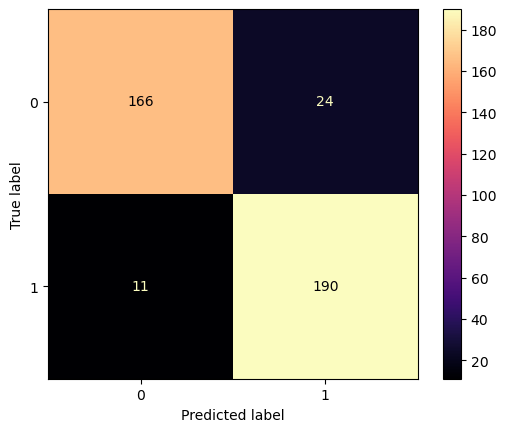

In [28]:
# Drop the seaborn style, so that we remove the white lines passing throguh the numbers 
sns.reset_orig()

# Create the confusion matrix by providing the true and the predicted values as arguments.
ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred,
    labels = clf.classes_,
    cmap = 'magma'
);

# How to read a confusion matrix?

# True negatives (TN): 166
# False positives (FP): 24
# False negatives (FN): 11
# True positives (TP): 190

In [29]:
# The classification report consists of the precision, recall and f1-score of each class as well as
# the overall accuracy of the model.
print(classification_report(y_test, y_test_pred, target_names = ['Ham', 'Spam']))

# Accuracy: (TN + TP) / all samples (TN+TP+FP+FN)
# Precision: TP / (TP + FP) --> correctly identified all ham or spam messages classified as ham or spam
# Recall: TP / (TP + FN) --> ham or spam comments that the model has caught
# F1-score: mean of precision and recall

              precision    recall  f1-score   support

         Ham       0.94      0.87      0.90       190
        Spam       0.89      0.95      0.92       201

    accuracy                           0.91       391
   macro avg       0.91      0.91      0.91       391
weighted avg       0.91      0.91      0.91       391



#### Adjusting the class_prior parameter

In [30]:
# Maybe we can achieve higher scores if we juggle with the class_priors?
# Print the class priors.
np.exp(clf.class_log_prior_)

array([0.48657289, 0.51342711])

In [31]:
# Create an instance of the Multinomial Naive Bayes classifier with class_priors
clf = MultinomialNB(class_prior = np.array([0.6, 0.4]))

# Fit the model to the training data
clf.fit(x_train_transf, y_train)

MultinomialNB(class_prior=array([0.6, 0.4]))

In [32]:
# Return the parameters of the classifier
clf.get_params()

{'alpha': 1.0, 'class_prior': array([0.6, 0.4]), 'fit_prior': True}

In [33]:
# Predict the target of the observations in the test set
y_test_pred = clf.predict(x_test_transf)

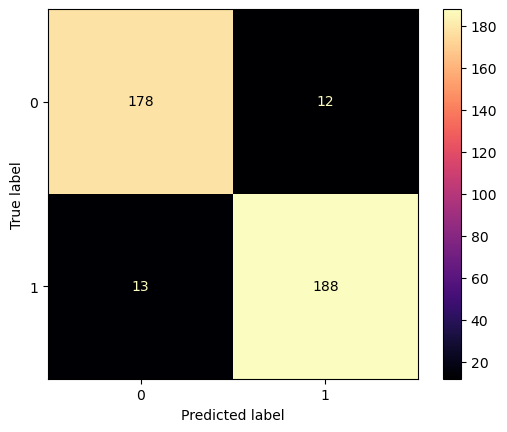

In [34]:
# Create the confusion matrix by providing the true and the predicted values as arguments.
ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred,
    labels = clf.classes_,
    cmap = 'magma'
);

# How to read a confusion matrix?

# True negatives (TN): 166
# False positives (FP): 24
# False negatives (FN): 11
# True positives (TP): 190

In [35]:
# As you can see, changing the priors improved our classification report
print(classification_report(y_test, y_test_pred, target_names = ['Ham', 'Spam']))

# Accuracy: TN + TP / all samples (TN+TP+FP+FN)
# Precision: TP / TP + FP --> correctly identified all ham or spam messages classified as ham or spam
# Recall: TP / TP + FN --> ham or spam comments that the model has caught
# F1-score: mean of precision and recall

              precision    recall  f1-score   support

         Ham       0.93      0.94      0.93       190
        Spam       0.94      0.94      0.94       201

    accuracy                           0.94       391
   macro avg       0.94      0.94      0.94       391
weighted avg       0.94      0.94      0.94       391



### Creating probability-distribution figures

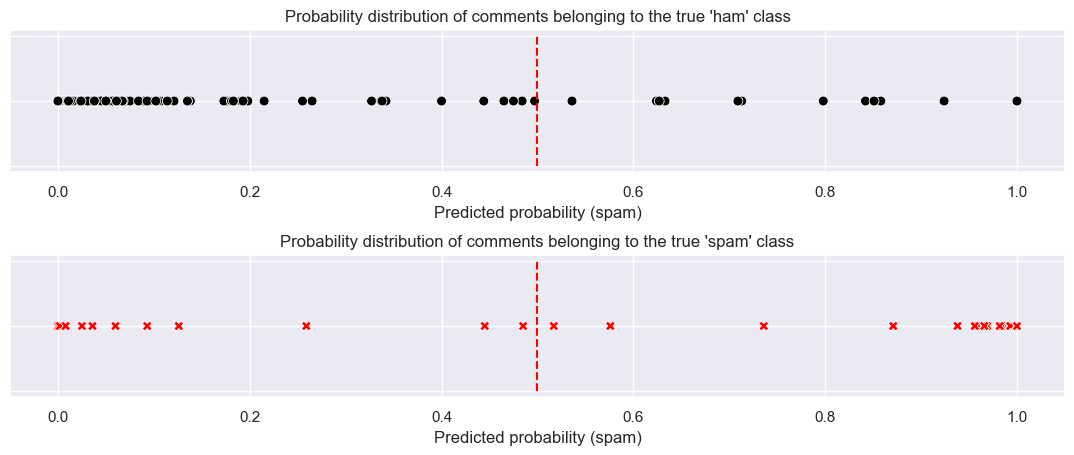

In [36]:
# For each observation, store its probability of being a spam. Round it to 3 digits after the decimal points.
# These probabilities will later serve as the x-coordinates of a scatter plot
spam_proba = clf.predict_proba(x_test_transf).round(3)[:,1];

# Create a new data frame which will store the true classes, the predicted classes and the predicted probability
# for an observation to belong to the spam class
df_scatter = pd.DataFrame()

# Create the columns of the data frame
df_scatter['True class'] = y_test
df_scatter['Predicted class'] = y_test_pred
df_scatter['Predicted probability (spam)'] = spam_proba

# Reset the index of the data frame, so that the indexing is sequential
df_scatter = df_scatter.reset_index(drop = True)

# Define two palettes for the different plots
palette_0 = sns.color_palette(['#000000'])
palette_1 = sns.color_palette(['#FF0000'])

# Create two new data frames. The first one stores the samples whose true class is 0.
# The second one stores the samples whose true class is 1.
df_scatter_0 = df_scatter[df_scatter['True class'] == 0].reset_index(drop = True)
df_scatter_1 = df_scatter[df_scatter['True class'] == 1].reset_index(drop = True)

# Set the seaborn style
sns.set()

# Create two subfigures, so that they are arranged in 2 rows and 1 column.
# Set the size of the figures
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,5))
fig.tight_layout(pad = 3)

# Create a scatter plot.
# On the x-axis, we have the predicted probability of a comment being a spam.
# The y-axis takes only one value - zero. We create an array full of zeros having a length equal to 
# the number of samples whose true class is 0.
# The 'data' parameter specifies the dataset we are drawing the columns from.
# The 'hue' parameter specifies the feature based on which the points are going to be colored. In this case,
# this feature has only a single class - the 0 class.
# The 's' parameter specifies the size of the points.
# The 'markers' parameter determines the shape of the points.
# The 'palette' parameter specifies the colors to be used in the plot.
# The 'style' parameter connects markers to classes.
# We have decided to set the 'legend' parameter equal to False as we have only one class in the plot. 
# We decide to remove the ticks from the y-axis as they can be chosen arbitrarily.
sns.scatterplot(x = 'Predicted probability (spam)', 
                y = np.zeros(df_scatter_0.shape[0]), 
                data = df_scatter_0,
                hue = 'True class', 
                s = 50,
                markers = ['o'],
                palette = palette_0,
                style = 'True class',
                legend = False, 
                ax = ax1).set(yticklabels=[])

# Set a title above the first plot.
ax1.set_title('Probability distribution of comments belonging to the true \'ham\' class')

# Create a red vertical dashed line passing through the point x = 0.5
# The first parameter specifies the x-coordinate.
# The second and third parameters specify the min and the max y-coordinates.
# We choose a dashed linestyle.
# We color the line in red.
ax1.vlines(0.5, -1, 1, linestyles = 'dashed', colors = 'red');

# The comments above apply to this plot. The code is adapted to the spam class
sns.scatterplot(x = 'Predicted probability (spam)', 
                y = np.zeros(df_scatter_1.shape[0]), 
                hue = 'True class', 
                data = df_scatter_1,
                s = 50,
                palette = palette_1,
                markers = ['X'],
                style = 'True class',
                legend = False, 
                ax = ax2).set(yticklabels=[])

# Set a title above the second plot.
ax2.set_title('Probability distribution of comments belonging to the true \'spam\' class')

# Create a red vertical dahsed line for the second plot
ax2.vlines(0.5, -1, 1, linestyles = 'dashed', colors = 'red');

# Legend:
# In the first plot, the values to the left of the red line are the TP (190) and to the right the FP (24)
# In the second plot, the values to the left of the red line are the TN (166) and to the right the FP (11)

### Making predictions

In [37]:
# Choose the messages whose class you want to predict and put them in a list.
# Using the vectorizer, transform the messages and store the result in a variable called 'predict_data'.
predict_data = vectorizer.transform(['This song is amazing!',
                                     'You can win 1m dollars right now, just click here!!!'])

In [38]:
# Call the 'predict()' method and use 'predict_data' as an argument.
# The classifier correctly predicts the two messages.
clf.predict(predict_data)

array([0, 1])